In [3]:
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import when, col, rank, monotonically_increasing_id, date_trunc
from pyspark.sql.types import StructType, StructField, TimestampType #, StringType, IntegerType, FloatType

# spark.stop()

In [2]:
conf = pyspark.SparkConf().setAll([
    ('spark.master', 'local[1]'),
    ('spark.app.name', 'App Name')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

spark.version

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/03 06:21:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


'3.3.1'

# Load in

In [4]:
'''set schema'''
# from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType
# dfSchema = StructType([       
#     StructField('PatientId', StringType(),True),
#     StructField('GlucoseDisplayTime', TimestampType(),True),
#     StructField('Value', FloatType(),True)
# ])

'''read in the file'''
# df = spark.read\
#     .option("mode", "DROPMALFORMED") \
#     .option("delimiter",",") \
#     .schema(dfSchema) \
#     .parquet('../../../../cephfs/stepped_glucose_data/step0_load/parquet_0_to_10/part-00000-02ebf86b-8495-41ff-acd3-ee636d696015-c000.snappy.parquet')
df = spark.read\
    .parquet('../../../../cephfs/stepped_glucose_data/step0_load/parquet_20_to_30/part-00000-5e0113c9-7310-4581-aad1-0cc30cdaf9c1-c000.snappy.parquet')

In [5]:
print("row count: ", df.count())
df.printSchema()
# df.head(5)
df.select("*").show(20)

row count:  21103760
root
 |-- PatientId: string (nullable = true)
 |-- Value: float (nullable = true)
 |-- GlucoseDisplayTime: timestamp (nullable = true)
 |-- GlucoseDisplayTimeRaw: string (nullable = true)
 |-- GlucoseDisplayDate: date (nullable = true)



+--------------------+-----+--------------------+---------------------+------------------+
|           PatientId|Value|  GlucoseDisplayTime|GlucoseDisplayTimeRaw|GlucoseDisplayDate|
+--------------------+-----+--------------------+---------------------+------------------+
|b+SG81ztOyK5NQEu3...|  0.0| 2022-09-18 18:29:29| 2022-09-18T18:29:...|        2022-09-18|
|b+SG81ztOyK5NQEu3...|  0.0| 2022-09-18 18:59:30| 2022-09-18T18:59:...|        2022-09-18|
|b+SG81ztOyK5NQEu3...|  0.0| 2022-09-18 18:34:30| 2022-09-18T18:34:...|        2022-09-18|
|uyTjoy2I97rYCplix...|  0.0|2022-09-19 12:41:...| 2022-09-19T12:41:...|        2022-09-19|
|uyTjoy2I97rYCplix...|  0.0|2022-09-19 12:16:...| 2022-09-19T12:16:...|        2022-09-19|
|uyTjoy2I97rYCplix...|  0.0|2022-09-19 12:46:...| 2022-09-19T12:46:...|        2022-09-19|
|uyTjoy2I97rYCplix...|  0.0|2022-09-19 14:31:...| 2022-09-19T14:31:...|        2022-09-19|
|uyTjoy2I97rYCplix...|  0.0|2022-09-19 12:06:...| 2022-09-19T12:06:...|        2022-09-19|

In [28]:
spark.stop()

# Prelim cleanup before filling

In [6]:
'''temp getting rid of any dates from before the actual start-date'''
df = df.filter("GlucoseDisplayDate > date'2022-02-20'")
df = df.filter("GlucoseDisplayDate < date'2022-03-03'")

print("row count: ", df.count())
df.show()

row count:  3750806
+--------------------+-----+--------------------+---------------------+------------------+
|           PatientId|Value|  GlucoseDisplayTime|GlucoseDisplayTimeRaw|GlucoseDisplayDate|
+--------------------+-----+--------------------+---------------------+------------------+
|VYkNdgKKd2wKCc+o0...|  0.0|2022-02-24 22:19:...| 2022-02-24T22:19:...|        2022-02-24|
|VYkNdgKKd2wKCc+o0...|  0.0|2022-02-24 21:49:...| 2022-02-24T21:49:...|        2022-02-24|
|VYkNdgKKd2wKCc+o0...|  0.0|2022-02-23 22:44:...| 2022-02-23T22:44:...|        2022-02-23|
|VYkNdgKKd2wKCc+o0...|  0.0|2022-02-24 22:34:...| 2022-02-24T22:34:...|        2022-02-24|
|jw822om9zvX2ZUZ+C...|  0.0|2022-02-24 19:34:...| 2022-02-24T19:34:...|        2022-02-24|
|jw822om9zvX2ZUZ+C...|  0.0|2022-02-24 19:19:...| 2022-02-24T19:19:...|        2022-02-24|
|jw822om9zvX2ZUZ+C...|  0.0|2022-02-24 18:59:...| 2022-02-24T18:59:...|        2022-02-24|
|jw822om9zvX2ZUZ+C...|  0.0|2022-02-24 18:34:...| 2022-02-24T18:34:...

In [15]:
21103760-3750806

17352954

In [14]:
df.select('GlucoseDisplayDate').distinct().collect()

[Row(GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(GlucoseDisplayDate=datetime.date(2022, 2, 22)),
 Row(GlucoseDisplayDate=datetime.date(2022, 2, 28)),
 Row(GlucoseDisplayDate=datetime.date(2022, 3, 1)),
 Row(GlucoseDisplayDate=datetime.date(2022, 2, 23)),
 Row(GlucoseDisplayDate=datetime.date(2022, 2, 21)),
 Row(GlucoseDisplayDate=datetime.date(2022, 2, 27)),
 Row(GlucoseDisplayDate=datetime.date(2022, 2, 26)),
 Row(GlucoseDisplayDate=datetime.date(2022, 2, 24)),
 Row(GlucoseDisplayDate=datetime.date(2022, 3, 2))]

### replace 0s with NaN, AND dropna
drop the NaNs because we don't want to mistakenly start or end with a NaN in the resampling steps

In [8]:
df = df.withColumn("Value", \
           when(col("Value")=="0", None) \
              .otherwise(col("Value")))
df = df.na.drop(subset=['PatientId','Value','GlucoseDisplayTime'])

print("row count: ", df.count())
df.show()

row count:  3571251
+--------------------+-----+-------------------+---------------------+------------------+
|           PatientId|Value| GlucoseDisplayTime|GlucoseDisplayTimeRaw|GlucoseDisplayDate|
+--------------------+-----+-------------------+---------------------+------------------+
|d0dv9A8no1AasCnoL...|133.0|2022-02-25 04:31:08| 2022-02-25T04:31:...|        2022-02-25|
|d0dv9A8no1AasCnoL...|148.0|2022-02-24 19:31:07| 2022-02-24T19:31:...|        2022-02-24|
|d0dv9A8no1AasCnoL...|147.0|2022-02-24 22:56:08| 2022-02-24T22:56:...|        2022-02-24|
|d0dv9A8no1AasCnoL...|158.0|2022-02-24 21:36:08| 2022-02-24T21:36:...|        2022-02-24|
|d0dv9A8no1AasCnoL...|141.0|2022-02-25 00:16:08| 2022-02-25T00:16:...|        2022-02-25|
|d0dv9A8no1AasCnoL...|145.0|2022-02-24 23:11:07| 2022-02-24T23:11:...|        2022-02-24|
|d0dv9A8no1AasCnoL...|201.0|2022-02-25 18:06:11| 2022-02-25T18:06:...|        2022-02-25|
|d0dv9A8no1AasCnoL...|155.0|2022-02-24 19:41:07| 2022-02-24T19:41:...|        20

### drop duplicate datetimes for each patient

In [9]:
from pyspark.sql import Window
from pyspark.sql.functions import rank, col, monotonically_increasing_id

window = Window.partitionBy('GlucoseDisplayTime','PatientId').orderBy('tiebreak')
df = (df
 .withColumn('tiebreak', monotonically_increasing_id())
 .withColumn('rank', rank().over(window))
 .filter(col('rank') == 1).drop('rank','tiebreak')
)

print("row count: ", df.count())
df.show()

row count:  3570967


+--------------------+-----+-------------------+---------------------+------------------+
|           PatientId|Value| GlucoseDisplayTime|GlucoseDisplayTimeRaw|GlucoseDisplayDate|
+--------------------+-----+-------------------+---------------------+------------------+
|v6Muwq9Wr+EIIodOO...|153.0|2022-02-21 00:19:39| 2022-02-21T00:19:...|        2022-02-21|
|v6Muwq9Wr+EIIodOO...|153.0|2022-02-21 00:24:39| 2022-02-21T00:24:...|        2022-02-21|
|Wo5LaLOXvDxy7vYwX...|221.0|2022-02-21 00:30:59| 2022-02-21T00:30:...|        2022-02-21|
|v6Muwq9Wr+EIIodOO...|154.0|2022-02-21 00:34:39| 2022-02-21T00:34:...|        2022-02-21|
|v6Muwq9Wr+EIIodOO...|154.0|2022-02-21 00:44:40| 2022-02-21T00:44:...|        2022-02-21|
|mHKJn550xt0PQLNy+...|166.0|2022-02-21 00:48:07| 2022-02-21T00:48:...|        2022-02-21|
|Wo5LaLOXvDxy7vYwX...|195.0|2022-02-21 00:50:58| 2022-02-21T00:50:...|        2022-02-21|
|mHKJn550xt0PQLNy+...|168.0|2022-02-21 00:53:07| 2022-02-21T00:53:...|        2022-02-21|
|v6Muwq9Wr

In [10]:
print("only lost", 3750806-3570967, "rows")

only lost 179839 rows


# fill in missing timestamps

* get rid of seconds
* get first and last date
* make a range that fills all those in
* make a dataframe of those dates
* merge og dataframe back into the new one along the dates

In [11]:
'''get rid of seconds'''
from pyspark.sql.functions import date_trunc

df = df.withColumn('GlucoseDisplayTime', date_trunc('minute', df.GlucoseDisplayTime))

print("row count: ", df.count())
df.show()

row count:  3570967


+--------------------+-----+-------------------+---------------------+------------------+
|           PatientId|Value| GlucoseDisplayTime|GlucoseDisplayTimeRaw|GlucoseDisplayDate|
+--------------------+-----+-------------------+---------------------+------------------+
|v6Muwq9Wr+EIIodOO...|153.0|2022-02-21 00:19:00| 2022-02-21T00:19:...|        2022-02-21|
|v6Muwq9Wr+EIIodOO...|153.0|2022-02-21 00:24:00| 2022-02-21T00:24:...|        2022-02-21|
|Wo5LaLOXvDxy7vYwX...|221.0|2022-02-21 00:30:00| 2022-02-21T00:30:...|        2022-02-21|
|v6Muwq9Wr+EIIodOO...|154.0|2022-02-21 00:34:00| 2022-02-21T00:34:...|        2022-02-21|
|v6Muwq9Wr+EIIodOO...|154.0|2022-02-21 00:44:00| 2022-02-21T00:44:...|        2022-02-21|
|mHKJn550xt0PQLNy+...|166.0|2022-02-21 00:48:00| 2022-02-21T00:48:...|        2022-02-21|
|Wo5LaLOXvDxy7vYwX...|195.0|2022-02-21 00:50:00| 2022-02-21T00:50:...|        2022-02-21|
|mHKJn550xt0PQLNy+...|168.0|2022-02-21 00:53:00| 2022-02-21T00:53:...|        2022-02-21|
|v6Muwq9Wr

### split by patient

In [54]:
'''get patient IDs (takes ~30 seconds to run this) (only 6325 patients)'''
patIds = [i.PatientId for i in df.select('PatientId').distinct().collect()]
patIds[0:10]

['w3byHxzYcuCWbH7Gvn6uxO/qFSRxEFGo8M4EC7HKi2E=',
 'BDIEttZRgW/oC8TBmA33OCMrCte7iUnd1ppJs0b8XZI=',
 'vH4j/sVPDk4luo9wfgyHaPGhwCIxZ5L5mRlRk8Se9F4=',
 'tCu+A/d9bWRBYQ6VCpvhuC4zOj0DOfqChQxRCYo7Poo=',
 'kXxwAcr9mfPzbKHKkwaCxK4Cf8e4UAWioOFi9BA8GwM=',
 'ER+gxKFxHvXyfESG6sxYwoE7IoQMUvDrSn1Tv3tzLKY=',
 'Zw997clFRcTAHrWiOlv01fcjptafxboYCEHbZ2kyrXU=',
 'L2yvv+kXYTaNN31CVnu5kYUv0qu7tZgVTnTFGRSjTM0=',
 'H24YXOcfrUrg312CBv0XvsL2x1TniFAVRqmZetYVHD8=',
 'Fo+LgUqZPK5pRUJ1OM5hZxQLIT3GxWBIOcCPuBj+tPY=']

In [13]:
len(patIds)

6711

In [59]:
'''save dataframe of just 1 patient'''
patient_str = "UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg="

subset = df.filter("PatientId = 'UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg='")

print("row count: ", subset.count())
subset.show()

row count:  333


+--------------------+-----+-------------------+---------------------+------------------+
|           PatientId|Value| GlucoseDisplayTime|GlucoseDisplayTimeRaw|GlucoseDisplayDate|
+--------------------+-----+-------------------+---------------------+------------------+
|UNrE+DKLY8WEQsGhg...|222.0|2022-02-25 10:49:00| 2022-02-25T10:49:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|218.0|2022-02-25 10:54:00| 2022-02-25T10:54:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|216.0|2022-02-25 10:59:00| 2022-02-25T10:59:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|211.0|2022-02-25 11:04:00| 2022-02-25T11:04:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|211.0|2022-02-25 11:09:00| 2022-02-25T11:09:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|205.0|2022-02-25 11:14:00| 2022-02-25T11:14:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|199.0|2022-02-25 11:19:00| 2022-02-25T11:19:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|201.0|2022-02-25 11:24:00| 2022-02-25T11:24:...|        2022-02-25|
|UNrE+DKLY

In [15]:
'''get first and last date (takes about 10 seconds per ten days of one patient)'''
minimum = subset.agg({'GlucoseDisplayTime': 'min'}).collect()[0][0]
maximum = subset.agg({'GlucoseDisplayTime': 'max'}).collect()[0][0]
minimum, maximum

(datetime.datetime(2022, 2, 25, 10, 49),
 datetime.datetime(2022, 2, 28, 14, 59))

#### asside for visuals and pandas

In [27]:
# subset.filter("GlucoseDisplayTime = timestamp'2022-02-25 10:49:00'").show()
subset.filter("GlucoseDisplayTime = timestamp'2022-02-28 14:59:00'").show()
# minimum, maximum

+--------------------+-----+-------------------+---------------------+------------------+
|           PatientId|Value| GlucoseDisplayTime|GlucoseDisplayTimeRaw|GlucoseDisplayDate|
+--------------------+-----+-------------------+---------------------+------------------+
|UNrE+DKLY8WEQsGhg...|105.0|2022-02-28 14:59:00| 2022-02-28T14:59:...|        2022-02-28|
+--------------------+-----+-------------------+---------------------+------------------+



In [22]:
# import matplotlib.pyplot as plt
temp = subset.toPandas()
print(temp.info())
temp.head()

/home/jovyan/glucose-data-analysis/glucose_venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PatientId              333 non-null    object        
 1   Value                  333 non-null    float32       
 2   GlucoseDisplayTime     333 non-null    datetime64[ns]
 3   GlucoseDisplayTimeRaw  333 non-null    object        
 4   GlucoseDisplayDate     333 non-null    object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 11.8+ KB
None


,PatientId,Value,GlucoseDisplayTime,GlucoseDisplayTimeRaw,GlucoseDisplayDate
0,UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=,222.0,2022-02-25 10:49:00,2022-02-25T10:49:20.000-08:00,2022-02-25
1,UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=,218.0,2022-02-25 10:54:00,2022-02-25T10:54:19.000-08:00,2022-02-25
2,UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=,216.0,2022-02-25 10:59:00,2022-02-25T10:59:19.000-08:00,2022-02-25
3,UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=,211.0,2022-02-25 11:04:00,2022-02-25T11:04:20.000-08:00,2022-02-25
4,UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=,211.0,2022-02-25 11:09:00,2022-02-25T11:09:19.000-08:00,2022-02-25


<AxesSubplot: xlabel='GlucoseDisplayTime', ylabel='Value'>

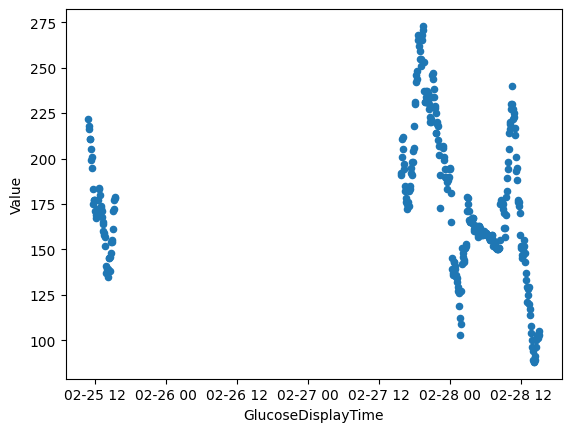

In [24]:
temp.plot.scatter(x='GlucoseDisplayTime', y='Value')

#### back to pyspark

In [45]:
'''make a range that fills all those in'''

from datetime import date, datetime, timedelta

def date_range_list(start_date, end_date):
    if start_date > end_date:
        raise ValueError("start_date must come before end_date")
    
    datetime_list = []
    curr_date = start_date
    while curr_date <= end_date:
        # yield curr_date
        datetime_list.append([curr_date])
        curr_date += timedelta(minutes=5)
    return datetime_list

datetime_list = date_range_list(minimum, maximum)

'''~~take out the datetimes that already exist in the dataframe~~
this doesn't work because datetime_list.append(curr_date) needs to be datetime_list.append([curr_date])'''
# datetime_list = list(set(datetime_list) - set(og_datetimes))

datetime_list

[[datetime.datetime(2022, 2, 25, 10, 49)],
 [datetime.datetime(2022, 2, 25, 10, 54)],
 [datetime.datetime(2022, 2, 25, 10, 59)],
 [datetime.datetime(2022, 2, 25, 11, 4)],
 [datetime.datetime(2022, 2, 25, 11, 9)],
 [datetime.datetime(2022, 2, 25, 11, 14)],
 [datetime.datetime(2022, 2, 25, 11, 19)],
 [datetime.datetime(2022, 2, 25, 11, 24)],
 [datetime.datetime(2022, 2, 25, 11, 29)],
 [datetime.datetime(2022, 2, 25, 11, 34)],
 [datetime.datetime(2022, 2, 25, 11, 39)],
 [datetime.datetime(2022, 2, 25, 11, 44)],
 [datetime.datetime(2022, 2, 25, 11, 49)],
 [datetime.datetime(2022, 2, 25, 11, 54)],
 [datetime.datetime(2022, 2, 25, 11, 59)],
 [datetime.datetime(2022, 2, 25, 12, 4)],
 [datetime.datetime(2022, 2, 25, 12, 9)],
 [datetime.datetime(2022, 2, 25, 12, 14)],
 [datetime.datetime(2022, 2, 25, 12, 19)],
 [datetime.datetime(2022, 2, 25, 12, 24)],
 [datetime.datetime(2022, 2, 25, 12, 29)],
 [datetime.datetime(2022, 2, 25, 12, 34)],
 [datetime.datetime(2022, 2, 25, 12, 39)],
 [datetime.date

In [46]:
'''make a dataframe of those dates'''

from pyspark.sql.types import StructType, StructField, TimestampType

deptSchema = StructType([       
    StructField('GlucoseDisplayTime', TimestampType(), True)
])

dt_df = spark.createDataFrame(data=datetime_list, schema = deptSchema)
dt_df.printSchema()
print("row count: ", dt_df.count())
dt_df.show(truncate=False)

root
 |-- GlucoseDisplayTime: timestamp (nullable = true)

row count:  915
+-------------------+
|GlucoseDisplayTime |
+-------------------+
|2022-02-25 10:49:00|
|2022-02-25 10:54:00|
|2022-02-25 10:59:00|
|2022-02-25 11:04:00|
|2022-02-25 11:09:00|
|2022-02-25 11:14:00|
|2022-02-25 11:19:00|
|2022-02-25 11:24:00|
|2022-02-25 11:29:00|
|2022-02-25 11:34:00|
|2022-02-25 11:39:00|
|2022-02-25 11:44:00|
|2022-02-25 11:49:00|
|2022-02-25 11:54:00|
|2022-02-25 11:59:00|
|2022-02-25 12:04:00|
|2022-02-25 12:09:00|
|2022-02-25 12:14:00|
|2022-02-25 12:19:00|
|2022-02-25 12:24:00|
+-------------------+
only showing top 20 rows



In [52]:
'''merge og dataframe back into the new one along the dates'''
# merged = df_1.union(df_2)
merged = subset.unionByName(dt_df, allowMissingColumns=True)

print("row count: ", merged.count())
merged.show(truncate=False)

row count:  1248


+--------------------------------------------+-----+-------------------+-----------------------------+------------------+
|PatientId                                   |Value|GlucoseDisplayTime |GlucoseDisplayTimeRaw        |GlucoseDisplayDate|
+--------------------------------------------+-----+-------------------+-----------------------------+------------------+
|UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=|222.0|2022-02-25 10:49:00|2022-02-25T10:49:20.000-08:00|2022-02-25        |
|UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=|218.0|2022-02-25 10:54:00|2022-02-25T10:54:19.000-08:00|2022-02-25        |
|UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=|216.0|2022-02-25 10:59:00|2022-02-25T10:59:19.000-08:00|2022-02-25        |
|UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=|211.0|2022-02-25 11:04:00|2022-02-25T11:04:20.000-08:00|2022-02-25        |
|UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=|211.0|2022-02-25 11:09:00|2022-02-25T11:09:19.000-08:00|2022-02-25        |
|UNrE+DKLY8WEQsGhgJWIhSB

In [53]:
'''get rid of the timestamps we already have (using the exact same method as from "drop duplicate datetimes for each patient" above)'''
window = Window.partitionBy('GlucoseDisplayTime').orderBy('tiebreak')
merged = (merged
 .withColumn('tiebreak', monotonically_increasing_id())
 .withColumn('rank', rank().over(window))
 .filter(col('rank') == 1).drop('rank','tiebreak')
)

print("row count: ", merged.count())
merged.show()

row count:  915


+--------------------+-----+-------------------+---------------------+------------------+
|           PatientId|Value| GlucoseDisplayTime|GlucoseDisplayTimeRaw|GlucoseDisplayDate|
+--------------------+-----+-------------------+---------------------+------------------+
|UNrE+DKLY8WEQsGhg...|222.0|2022-02-25 10:49:00| 2022-02-25T10:49:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|218.0|2022-02-25 10:54:00| 2022-02-25T10:54:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|216.0|2022-02-25 10:59:00| 2022-02-25T10:59:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|211.0|2022-02-25 11:04:00| 2022-02-25T11:04:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|211.0|2022-02-25 11:09:00| 2022-02-25T11:09:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|205.0|2022-02-25 11:14:00| 2022-02-25T11:14:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|199.0|2022-02-25 11:19:00| 2022-02-25T11:19:...|        2022-02-25|
|UNrE+DKLY8WEQsGhg...|201.0|2022-02-25 11:24:00| 2022-02-25T11:24:...|        2022-02-25|
|UNrE+DKLY

In [60]:
'''filling out the columns as needed:
    -PatientId should be all the same string
    -GlucoseDisplayTimeRaw should be used for checking the dates here, but that implementation will have to come later
    -GlucoseDisplayDate is not filled out at this time
'''
merged = merged.drop('GlucoseDisplayTimeRaw') #someday i'll have time to use this as the double-checker
merged = merged.fillna(patient_str, subset='PatientId')

print("row count: ", merged.count())
merged.head(80)

row count:  915


[Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=222.0, GlucoseDisplayTime=datetime.datetime(2022, 2, 25, 10, 49), GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=218.0, GlucoseDisplayTime=datetime.datetime(2022, 2, 25, 10, 54), GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=216.0, GlucoseDisplayTime=datetime.datetime(2022, 2, 25, 10, 59), GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=211.0, GlucoseDisplayTime=datetime.datetime(2022, 2, 25, 11, 4), GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=211.0, GlucoseDisplayTime=datetime.datetime(2022, 2, 25, 11, 9), GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=205.0, GlucoseDisp

In [61]:
'''fill in the values'''

# filler = subset.agg({'Value': 'median'}).collect()[0][0]
filler = subset.agg({'Value': 'avg'}).collect()[0][0]

filled_df = merged.fillna(filler, subset='Value')

print("row count: ", filled_df.count())
filled_df.head(60)

row count:  915


[Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=222.0, GlucoseDisplayTime=datetime.datetime(2022, 2, 25, 10, 49), GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=218.0, GlucoseDisplayTime=datetime.datetime(2022, 2, 25, 10, 54), GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=216.0, GlucoseDisplayTime=datetime.datetime(2022, 2, 25, 10, 59), GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=211.0, GlucoseDisplayTime=datetime.datetime(2022, 2, 25, 11, 4), GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=211.0, GlucoseDisplayTime=datetime.datetime(2022, 2, 25, 11, 9), GlucoseDisplayDate=datetime.date(2022, 2, 25)),
 Row(PatientId='UNrE+DKLY8WEQsGhgJWIhSBlMYSn9szanvBQuoGKSjg=', Value=205.0, GlucoseDisp